In [1]:
%matplotlib inline

import pandas as pd
import matplotlib.pyplot as plt
import watexr_utils as wx

plt.style.use('ggplot')

# Checking ERA5 and System 5 datasets

Basic checking of the ERA5 and System 5 data downloaded and processed in notebooks 05 and 07.

## 1. User input

Choose a model type (`gotm` or `bayes_net`) and valid season (see `07_s5_download_combos.xlsx`) for further processing.

In [2]:
# Model type ('bayes_net' or 'gotm')
model = 'gotm'

# Season (must be valid for given model_type)
season = 'spring'

# Members
members = range(1, 26)

## 2. Read datasets

The code below reads the ERA5 data, the merged (i.e. combined hindcast and forecast) S5 data and the bias-corrected version of the S5 dataset, all generated in notebook 07.

In [3]:
# Read ERA5 data
era5_path = r'/home/jovyan/projects/WATExR/Norway_Morsa/Data/Meteorological/06_era5/era5_morsa_1980-2019_daily.csv'
era5 = pd.read_csv(era5_path, index_col=0, parse_dates=True)

# Read S5 data
df_list = []
for mem in members:
    s5_path = f'/home/jovyan/projects/WATExR/Norway_Morsa/Data/Meteorological/07_s5_seasonal/s5_morsa_{model}_merged_{season}_member{mem:02d}.csv'
    df = pd.read_csv(s5_path, index_col=0, parse_dates=True)
    df.columns = [f'{i}_{mem:02d}' for i in df.columns]
    df_list.append(df)
    
s5 = pd.concat(df_list, axis=1, sort=True)

# Read bias-corrected S5 data
df_list = []
for mem in members:
    s5_path = f'/home/jovyan/projects/WATExR/Norway_Morsa/Data/Meteorological/07_s5_seasonal/s5_morsa_{model}_merged_{season}_member{mem:02d}_bc.csv'
    df = pd.read_csv(s5_path, index_col=0, parse_dates=True)
    df.columns = [f'{i}_{mem:02d}' for i in df.columns]
    df_list.append(df)
    
s5_bc = pd.concat(df_list, axis=1, sort=True)

# Get only matching dates from ERA5 data
era5 = era5[era5.index.isin(s5.index)]

## 3. Target plots with and without bias correction

The left column of plots compares the **median** S5 forecast to the ERA5 data **without** bias correction; the right-hand column includes bias correction of the S5 data.

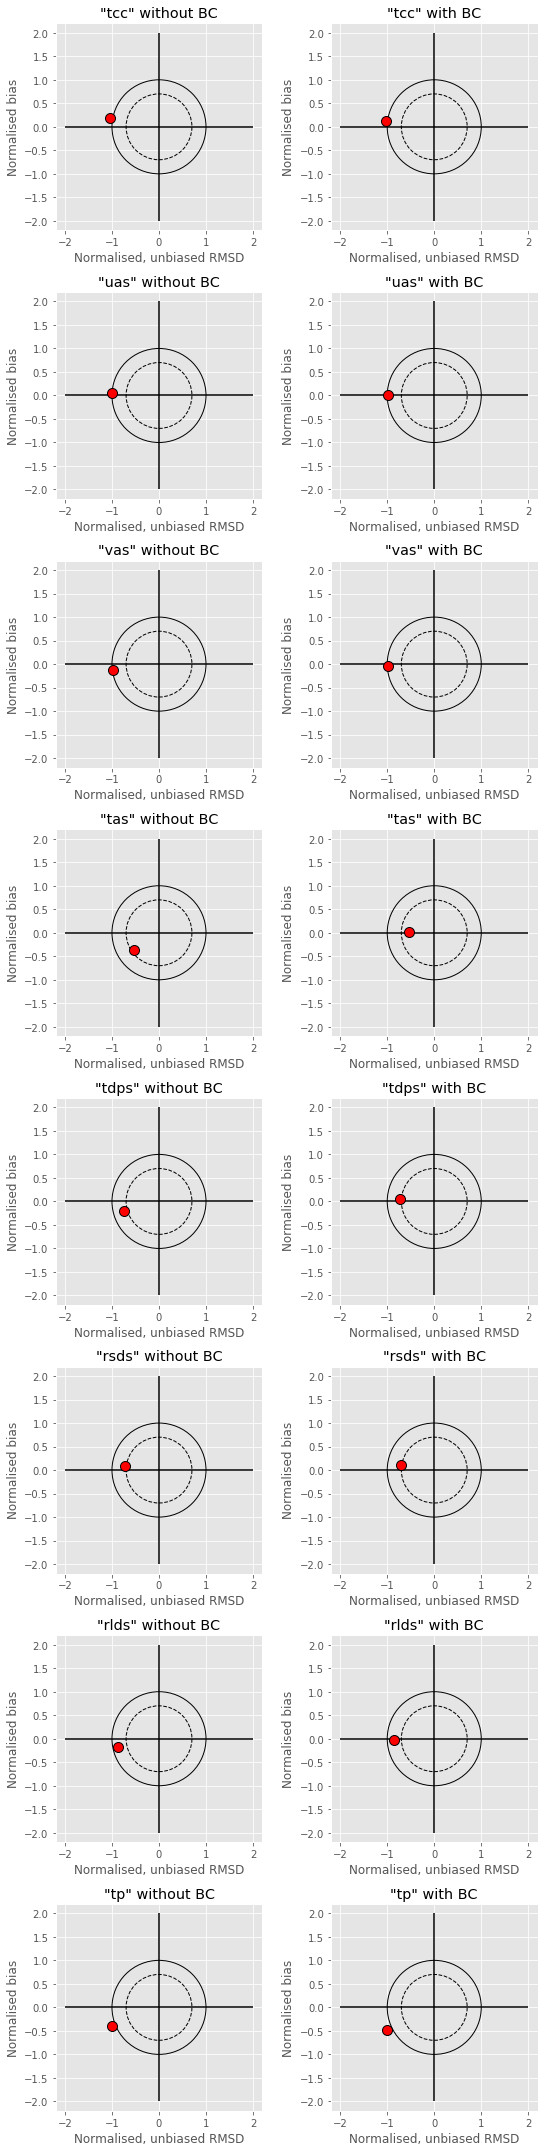

In [4]:
# Setup plot
fig, axes = plt.subplots(nrows=8, 
                         ncols=2, 
                         figsize=(8, 30), 
                         subplot_kw={'aspect':'equal'},
                        )

# Loop over vars
for idx, par in enumerate(era5.columns):
    par_cols = [f'{par}_{i:02d}' for i in members]
    era5_par = era5[[par]]
    s5_par = s5[par_cols].quantile([0.5], axis=1).T
    s5_par.columns = [str(i) for i in s5_par]
    s5_bc_par = s5_bc[par_cols].quantile([0.5], axis=1).T
    s5_bc_par.columns = [f'{i}_bc' for i in s5_bc_par]
    
    wx.target_plot(s5_par['0.5'], era5[par], ax=axes[idx, 0], title=f'"{par}" without BC')
    wx.target_plot(s5_bc_par['0.5_bc'], era5[par], ax=axes[idx, 1], title=f'"{par}" with BC')
    
plt.tight_layout()
plt.savefig(f'./plots/morsa_target_plots_{model}_{season}.png', dpi=200)

## 4. Time series with and without bias correction

For the specified year, the code below produces time series plots showing the ERA5 data, together with the **median** and **95% CI** for S5 predictions (both with and without bias correction). Only one year is plotted at a time to keeps things reasonably clean.

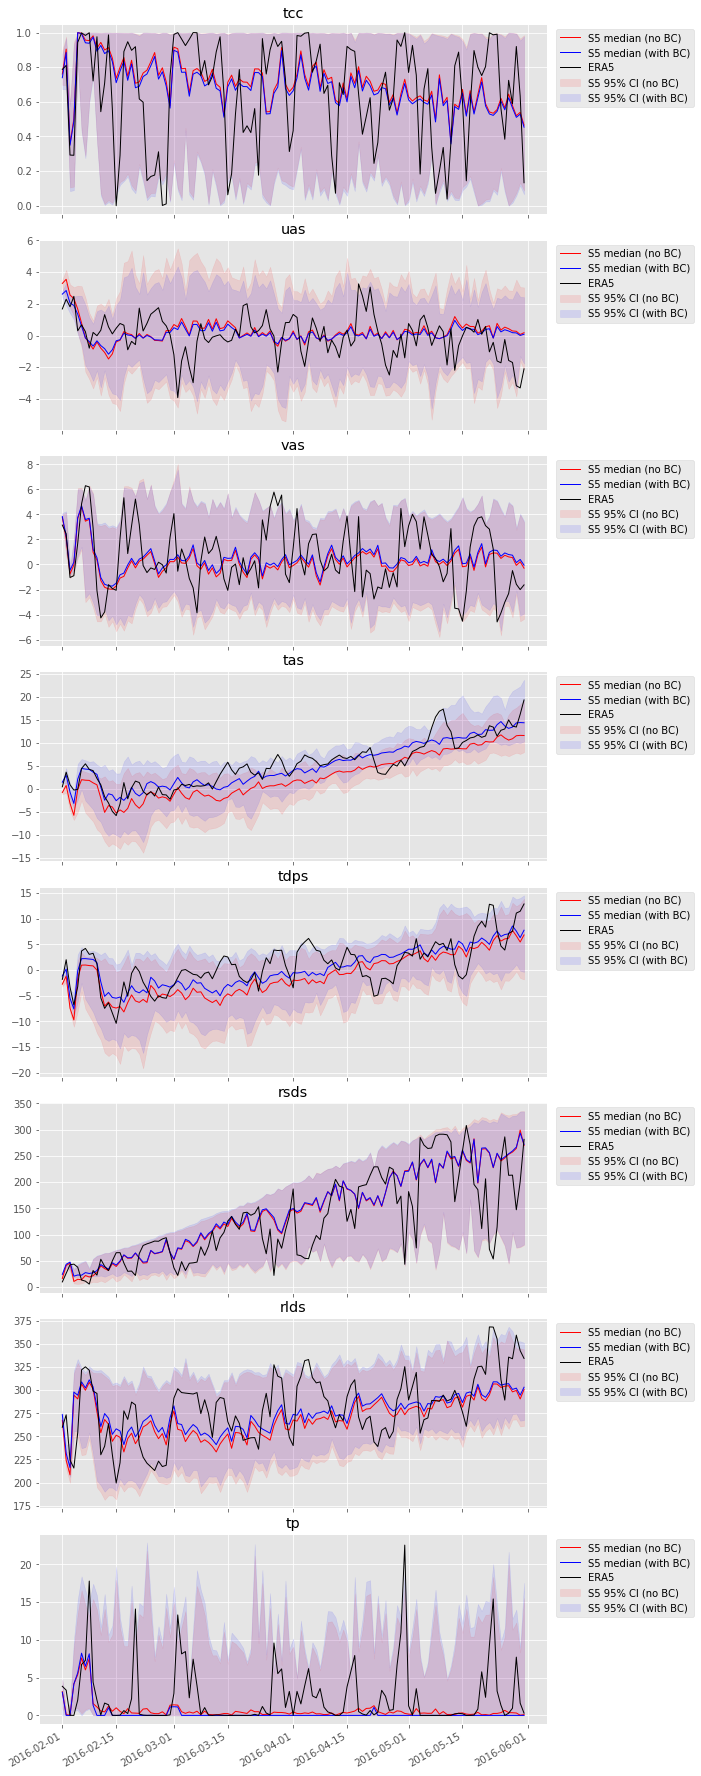

In [6]:
# Year of interest (1993 to 2019)
year = 2016

# Setup plot
fig, axes = plt.subplots(nrows=8, 
                         ncols=1, 
                         figsize=(10,30), 
                         sharex=True,
                        )

# Loop over vars
for idx, par in enumerate(era5.columns):
    par_cols = [f'{par}_{i:02d}' for i in members]
    era5_par = era5[[par]][era5.index.year == year]
    s5_par = s5[par_cols].quantile([0.025, 0.5, 0.975], axis=1).T[s5.index.year == year]
    s5_par.columns = [str(i) for i in s5_par]
    s5_bc_par = s5_bc[par_cols].quantile([0.025, 0.5, 0.975], axis=1).T[s5_bc.index.year == year]
    s5_bc_par.columns = [f'{i}_bc' for i in s5_bc_par]

    # 95% CI without BC
    axes[idx].fill_between(s5_par.index, 
                           s5_par['0.025'], 
                           s5_par['0.975'], 
                           color='r', 
                           alpha=0.1,
                           label='S5 95% CI (no BC)',
                          )

    # 95% CI with BC
    axes[idx].fill_between(s5_bc_par.index, 
                           s5_bc_par['0.025_bc'], 
                           s5_bc_par['0.975_bc'], 
                           color='b', 
                           alpha=0.1,
                           label='S5 95% CI (with BC)',
                          )

    # Median without BC
    axes[idx].plot(s5_par.index, 
                   s5_par['0.5'], 
                   color='r', 
                   lw=1, 
                   label='S5 median (no BC)',
                  )

    # Median with BC
    axes[idx].plot(s5_bc_par.index, 
                   s5_bc_par['0.5_bc'], 
                   color='b', 
                   lw=1, 
                   label='S5 median (with BC)',
                  )

    # ERA5
    axes[idx].plot(era5_par.index, 
                   era5_par[par], 
                   color='k', 
                   lw=1, 
                   label='ERA5',
                  )

    axes[idx].set_title(par)
    axes[idx].legend(bbox_to_anchor=(1.3, 1))
    
plt.tight_layout()
fig.autofmt_xdate()
plt.savefig(f'./plots/morsa_timeseries_plots_{model}_{season}_{year}.png', dpi=200)